In [22]:
import numpy as np
import sys, os, h5py, re
from trajencoder.dmp.dmp import DMP
import matplotlib.pyplot as plt
from learning_utils import prepare_data, DMP_reconstruct, calc_loss

### prepare data

In [18]:
DMP_ORDER = 25
X, Y, _ = prepare_data("../data/training/2-dof-no-velocity/training_DMP25_D7.hdf5")

In [19]:
Y.shape

(1764, 51)

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import PolynomialFeatures
from algpr.gpr import GaussianProcessRegressor
from algpr.kernels import RBF as rbf

In [5]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, Y)

clf = KernelRidge(kernel=RBF(length_scale=2))
clf.fit(X, Y)

poly = PolynomialFeatures(2)
X_rr = poly.fit_transform(X)
RR = Ridge(alpha=1.0)
RR.fit(X_rr, Y)

gpr = GaussianProcessRegressor(kernel=rbf(l=2.9))
gpr.fit(X, Y)

The evidence is:  -2.875355612020128e+18


-2.875355612020128e+18

In [6]:
Y[Y > 300]

array([], dtype=float64)

In [7]:
Xv, Yv, Trueth = prepare_data("../data/testing/2-dof-no-velocity/validating_DMP25_D4.hdf5")
Xv_rr = poly.fit_transform(Xv)

In [8]:
# pred = neigh.predict(Xv)
# pred = clf.predict(Xv)
# pred = RR.predict(Xv_rr)
pred = gpr.predict(Xv)

In [9]:
import time
start = time.time()
for _ in range(100):
    _ = gpr.predict(Xv[0].reshape(1,-1))
end = time.time()

print("Kernel ridge regression: ", (end - start) / 100 * 1000, "ms")

Kernel ridge regression:  0.6677651405334473 ms


In [10]:
pred.shape

(36, 51)

In [11]:
for i in range(len(Yv)):
    whichone = i
    pred_y = pred[whichone, :2*DMP_ORDER].reshape(DMP_ORDER,2)
    pred_length = pred[whichone, -1]
    target_y = Yv[whichone, :2*DMP_ORDER].reshape(DMP_ORDER,2)
    target_length = Yv[whichone, -1]
    # choose one to visualize
    q = Trueth[whichone]
    length = len(q)
    res_q, t1, t2 = DMP_reconstruct(target_y, DMP_ORDER, q[0], q[-1], int(target_length), 2)
    res_q_, t1_, t2_ = DMP_reconstruct(pred_y, DMP_ORDER, q[0], q[-1], int(pred_length), 2)
    plt.figure(figsize=[10,7])
    plt.plot(t1, q, '-.r', label='target')
    plt.plot(t2, res_q, '-b', label='encoded')
    plt.plot([t1[-1],t1[-1]],[np.min(q),np.max(q)], '-.r')
    plt.plot([t2_[-1],t2_[-1]],[np.min(res_q_),np.max(res_q_)], '-.c')
    plt.plot(t2_, res_q_, '-c', label='predict')
    plt.xlabel("Time [s]")
    plt.ylabel("Angular degree [rad]")
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    plt.legend(handles, labels, loc='best')
    plt.grid()
    plt.savefig("../plots/ordinary/{}.jpg".format(i), dpi=200)
    plt.close()

### Quantitative evaluation

In [12]:
error_time_l, error_with_q_l, evidence_l = [], [], []
import tqdm
for oder in tqdm.tqdm(range(1,13)):
#     clf = KernelRidge(kernel=RBF(length_scale=oder*0.2))
#     clf.fit(X, Y)
#     pred = clf.predict(Xv)
    
#     poly = PolynomialFeatures(oder)
#     X_rr = poly.fit_transform(X)
#     RR = Ridge(alpha=oder)
#     RR.fit(X_rr,Y)
#     Xv_rr = poly.fit_transform(Xv)
#     pred = RR.predict(Xv_rr)
    
#     neigh = KNeighborsRegressor(n_neighbors=oder)
#     neigh.fit(X, Y)
#     pred = neigh.predict(Xv)

    gpr = GaussianProcessRegressor(kernel=rbf(l=oder*0.2))
    evidence = gpr.fit(X, Y)
    pred = gpr.predict(Xv)
    error_time, error_with_q = calc_loss(pred, Yv, Trueth, DMP_ORDER)
    error_time_l.append(error_time)
    error_with_q_l.append(error_with_q)
    evidence_l.append(evidence)

  0%|                                                    | 0/12 [00:00<?, ?it/s]

The evidence is:  -280444421.57706714


  8%|███▋                                        | 1/12 [00:01<00:13,  1.19s/it]

The evidence is:  -261916032.6147036


 17%|███████▎                                    | 2/12 [00:02<00:10,  1.07s/it]

The evidence is:  -139174061.684537


 25%|███████████                                 | 3/12 [00:03<00:08,  1.01it/s]

The evidence is:  -64896034.28861807


 33%|██████████████▋                             | 4/12 [00:03<00:07,  1.05it/s]

The evidence is:  -42257033.419303246


 42%|██████████████████▎                         | 5/12 [00:04<00:06,  1.07it/s]

The evidence is:  -73075718.34544629


 50%|██████████████████████                      | 6/12 [00:05<00:05,  1.05it/s]

The evidence is:  -587465994.0293776


 58%|█████████████████████████▋                  | 7/12 [00:06<00:04,  1.07it/s]

The evidence is:  -10368529203.708344


 67%|█████████████████████████████▎              | 8/12 [00:07<00:03,  1.08it/s]

The evidence is:  -243278006222.58722


 75%|█████████████████████████████████           | 9/12 [00:08<00:02,  1.09it/s]

The evidence is:  -6244688157166.531


 83%|███████████████████████████████████▊       | 10/12 [00:09<00:01,  1.10it/s]

The evidence is:  -157468256995410.62


 92%|███████████████████████████████████████▍   | 11/12 [00:10<00:00,  1.11it/s]

The evidence is:  -3664936879498576.0


100%|███████████████████████████████████████████| 12/12 [00:11<00:00,  1.07it/s]


In [13]:
lbx = [-2,-2,-2,-2]
ubx = [2, 2, 2, 2]

11


3.400247412810291

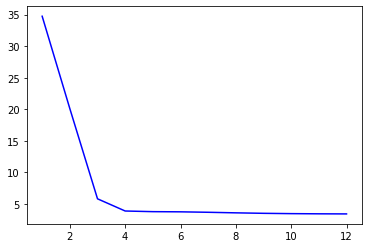

In [14]:
plt.plot(range(1,13), error_with_q_l, '-b')
print(np.argmin(error_with_q_l))
error_with_q_l[11]

11


0.004111111111111113

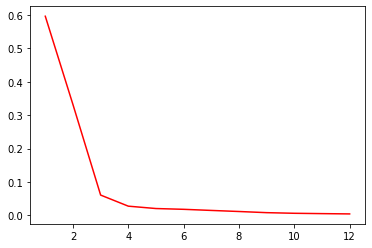

In [15]:
plt.plot(range(1,13), error_time_l, '-r')
print(np.argmin(error_time_l))
error_time_l[11]

RR with poly feature:0.008 3.978  
KRR with RBF kernel: 0.011 3.694  
6NN: 0.005 3.528  
GPR with RBF kernel: 0.0041 3.394